In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Set the path to the dataset
train_data_dir = '/content/drive/MyDrive/Univ/Semester 5/JST/CNN/train'
test_data_dir = '/content/drive/MyDrive/Univ/Semester 5/JST/CNN/test'

In [ ]:
# Define parameters
input_shape = (224, 224, 3)
batch_size = 32
epochs = 10
learning_rate = 0.00001

In [ ]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Data augmentation for the test set (tanpa rescaling)
test_datagen = ImageDataGenerator()

In [ ]:
# Load the MobileNetV3Small model with pre-trained weights
base_model_small = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)

# Load the MobileNetV3Large model with pre-trained weights
base_model_large = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
# Fine-tuning: Unfreeze some layers
for layer in base_model_large.layers[-20:]:
    layer.trainable = True

In [ ]:
# Build the CNN model
model = models.Sequential()
model.add(base_model_large)

In [ ]:
# Add the remaining layers
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Data preparation
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 2278 images belonging to 3 classes.
Found 569 images belonging to 3 classes.


In [ ]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // batch_size)

Epoch 1/10
71/71 [==============================] - 628s 8s/step - loss: 1.4659 - accuracy: 0.3584 - val_loss: 1.3022 - val_accuracy: 0.3327
Epoch 2/10
71/71 [==============================] - 37s 514ms/step - loss: 1.2867 - accuracy: 0.4092 - val_loss: 1.2330 - val_accuracy: 0.3511
Epoch 3/10
71/71 [==============================] - 38s 541ms/step - loss: 1.1866 - accuracy: 0.4435 - val_loss: 1.1857 - val_accuracy: 0.3732
Epoch 4/10
71/71 [==============================] - 37s 516ms/step - loss: 1.1025 - accuracy: 0.4773 - val_loss: 1.1502 - val_accuracy: 0.3824
Epoch 5/10
71/71 [==============================] - 36s 504ms/step - loss: 1.0758 - accuracy: 0.5018 - val_loss: 1.1089 - val_accuracy: 0.4191
Epoch 6/10
71/71 [==============================] - 40s 567ms/step - loss: 1.0307 - accuracy: 0.5111 - val_loss: 1.0757 - val_accuracy: 0.4338
Epoch 7/10
71/71 [==============================] - 36s 503ms/step - loss: 0.9797 - accuracy: 0.5383 - val_loss: 1.0417 - val_accuracy: 0.4540
E

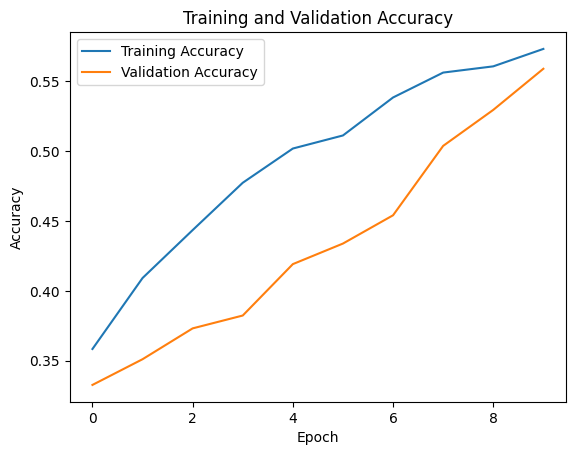

In [ ]:
# Visualize training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

17/17 [==============================] - 2s 97ms/step - loss: 0.9241 - accuracy: 0.5607


In [ ]:
# Generate predictions
y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes[:len(y_pred_classes)]  # Sesuaikan ukuran y_true_classes

17/17 [==============================] - 3s 95ms/step


In [ ]:
# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.47      0.44       213
           1       0.36      0.29      0.32       207
           2       0.31      0.34      0.33       124

    accuracy                           0.37       544
   macro avg       0.36      0.37      0.36       544
weighted avg       0.37      0.37      0.37       544

Confusion Matrix:
 [[100  70  43]
 [ 98  60  49]
 [ 44  38  42]]


In [ ]:
# Save the model
model.save('emotion_classification_mobilenetv3_model.h5', include_optimizer=False)  # Menyimpan model tanpa optimizer

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Save results to a Google Sheet
results_df = pd.DataFrame({
    'Model': ['MobileNetV3'],
    'Accuracy': [test_acc],
    'Loss': [test_loss],
    'Additional Metrics': ['F1 Score, etc.']
})

results_df.to_csv('model_results.csv', index=False)